In [51]:
from astropy import units as u
from astropy import time
import astropy
import numpy as np

from poliastro import iod
from poliastro.bodies import Body,Mars, Earth, Venus, Jupiter, Saturn, Uranus, Neptune, Sun, Europa, Ganymede, Callisto, Io, Titan
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.frames import Planes
from poliastro.frames.fixed import JupiterFixed
from poliastro.frames.equatorial import JupiterICRS
from astroquery.jplhorizons import Horizons
from copy import deepcopy

from scipy import ndimage
from scipy.spatial.transform import Rotation as scipyRot

from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
import math
import matplotlib.pyplot as plt
# More info: https://plotly.com/python/renderers/
import plotly.io as pio
from poliastro.util import norm, time_range
pio.renderers.default = "plotly_mimetype+notebook_connected"
import weakref
from astropy.coordinates import solar_system_ephemeris
from collections.abc import Mapping
from poliastro.extra_util import  match_astro_query_num,  get_single_burn_elliptical_hohmann ,match_orbit_plane,  search_for_resonant_orbit


solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

In [52]:
##Dates
#From general trajectory, we can arrive conservatively between june 17th 2037 & 6th august
arrival_date_first=time.Time("2037-06-17 00:01", scale="utc").tdb
arrival_date_second=time.Time("2037-06-21 00:01", scale="utc").tdb  
arrival_dates=time_range(arrival_date_first, end=arrival_date_second, periods=50)
sim_end_date = time.Time("2038-09-01 00:01", scale="utc").tdb

simulation_epoch=time_range(start=arrival_date_first,end=sim_end_date,periods=50)


io_ephem = Ephem.from_horizons(501,epochs= simulation_epoch, attractor= Jupiter, plane=Planes.EARTH_ECLIPTIC)#Io is 501
ganymede_ephem = Ephem.from_horizons(503,epochs= simulation_epoch, attractor= Jupiter, plane=Planes.EARTH_ECLIPTIC)#Ganymede is 503
europa_ephem = Ephem.from_horizons(502,epochs= simulation_epoch, attractor= Jupiter, plane=Planes.EARTH_ECLIPTIC)#Europa is 502
callisto_ephem = Ephem.from_horizons(504,epochs= simulation_epoch, attractor= Jupiter, plane=Planes.EARTH_ECLIPTIC) 


##Orbital Insertion Parameters
c3 = 150*u.km**2/u.s**2  
r_perijove = Jupiter.R+200000 * u.km
r_apijove = Jupiter.R+5e6*u.km

placeholder_io_orbit=Orbit.from_ephem(Jupiter,io_ephem,arrival_date_first)
placeholder_ganymede_orbit=Orbit.from_ephem(Jupiter,ganymede_ephem,arrival_date_first)
placeholder_callisto_orbit=Orbit.from_ephem(Jupiter,callisto_ephem,arrival_date_first)
placeholder_europa_orbit=Orbit.from_ephem(Jupiter,europa_ephem,arrival_date_first)

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"



/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/astropy/units/decorators.py:302: UserWarning:

Wrapping true anomaly to -π <= nu < π



Burn of 60.04909577745548 m / s
Starting in 5071492 x 271492 km x 2.3 deg orbit around Jupiter (♃) at epoch 2037-06-21 00:01:00.000 (UTC) orbit with period 28.2 d


/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 150 of "dubious year (Note 4)"



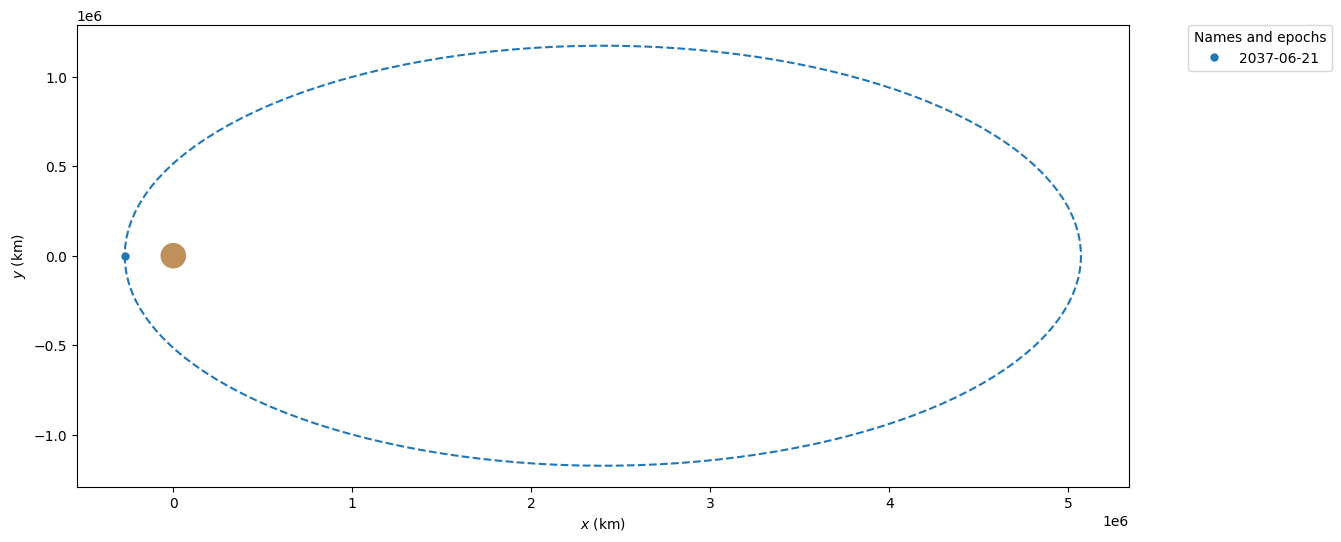

In [53]:
arrival_date=arrival_date_first
plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)

lowest_dv=1000*u.m/u.s
character=[]



#arrival date is date of insertion into jupiter orbit
for arrival_date in arrival_dates:   
    a_exit = (r_perijove+r_apijove)/2
    ecc_exit = (r_perijove-r_apijove)/(r_perijove+r_apijove)


    arrival_orbit = Orbit.from_classical(
        Jupiter,
        a_exit,
        ecc_exit,
        placeholder_ganymede_orbit.inc,
        placeholder_ganymede_orbit.raan,
        0 * u.deg,
        180 * u.deg,  
        time.Time(arrival_date, scale="utc"),
        plane=Planes.EARTH_ECLIPTIC
    )
    for tof in range(15,35)*u.day:
        ganymede_orb= placeholder_ganymede_orbit.propagate(arrival_date+tof)
        lambert=Maneuver.lambert(arrival_orbit,ganymede_orb,M=0)
        dv=np.linalg.norm(lambert[0][1])
        if dv<lowest_dv:
            lowest_dv=dv
            character=[arrival_date,tof,arrival_orbit,lambert]
# print(lowest_dv)
# print(character)
arrival_date_final=character[0]
tof_final=character[1]

# dum1,dum2,dum3,dum4,dum5=get_single_burn_elliptical_hohmann(Jupiter,Ganymede,arrival_orbit,45*u.day,65*u.day)
print(f"Burn of {lowest_dv}")
print(f"Starting in {character[2]} orbit with period {character[2].period.to(u.day):.1f}")
plotter.plot(character[2])

Entered into 271491 x 4888102 km x 2.3 deg orbit around Jupiter (♃) at epoch 2037-06-21 00:01:00.000 (UTC), apijove 68.4 RJ
with perijove 199999.08968634758 km


/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 150 of "dubious year (Note 4)"



Period of insertion orbit: 26.769119407058852 d
Flew past Ganymede with v infinity 11.93854106687188 km / s


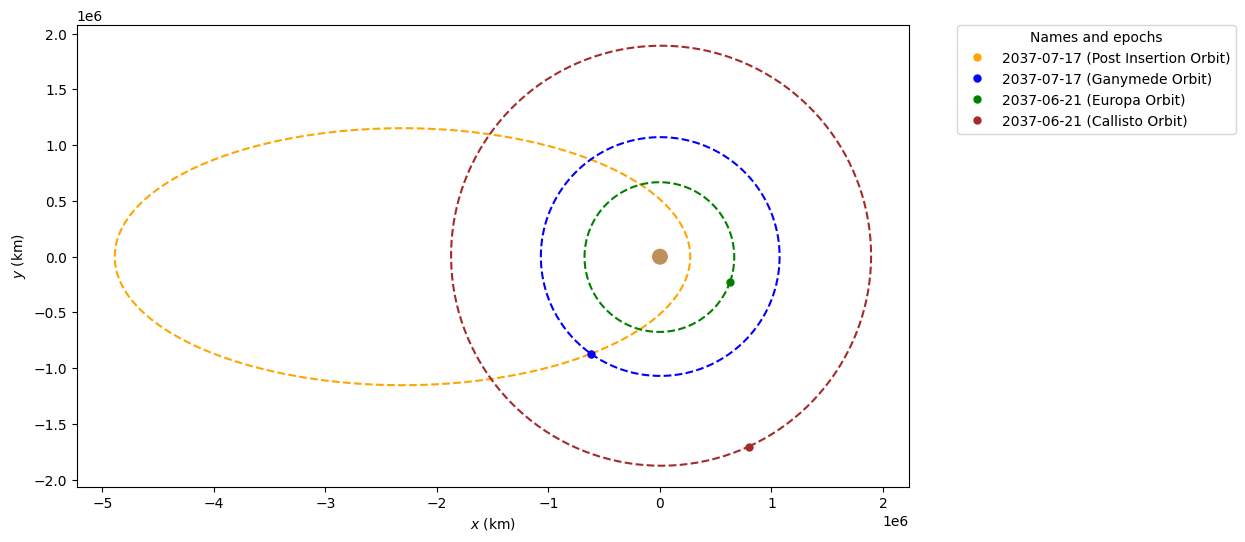

In [54]:
first_assist_date=arrival_date_final+tof_final

ganymede_orb=placeholder_ganymede_orbit.propagate(first_assist_date)
europa_orb=placeholder_europa_orbit.propagate(arrival_date_final)
callisto_orb=placeholder_callisto_orbit.propagate(arrival_date_final)

plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
post_insertion_orb,dummy=character[2].apply_maneuver(character[3],intermediate=True)
print(f"Entered into {post_insertion_orb}, apijove {(post_insertion_orb.r_a.to(u.km)/Jupiter.R.to(u.km)).value:.1f} RJ")
print(f"with perijove {post_insertion_orb.r_p.to(u.km)-Jupiter.R.to(u.km)}")

post_insertion_orb=post_insertion_orb.propagate(first_assist_date)

plotter.plot(post_insertion_orb, label="Post Insertion Orbit", color="orange")
plotter.plot(ganymede_orb, label="Ganymede Orbit", color="blue")    
# plotter.plot(dummy, label="Transfer Maneuver", color="red")
plotter.plot(europa_orb, label="Europa Orbit", color="green")
plotter.plot(callisto_orb, label="Callisto Orbit", color="brown")
print(f"Period of insertion orbit: {post_insertion_orb.period.to(u.day)}")
v_inf=post_insertion_orb.rv()[1]-ganymede_orb.rv()[1]
print(f"Flew past Ganymede with v infinity {np.linalg.norm(v_inf.to(u.km/u.s))}")


Ok, so from general trajectory, we have an arrival at Ganymede on 17th August 2037 from an insertion on 17th June with ~(0.5+0.13)km/s DV. 




-find direction that slows you down relative to Jupiter
-look for orbits that are rational multiple of orbit of the moon

GANYMEDE ENCOUNTER #1
Found 3:8 resonance: period=18.97 d, r_p=2644100 m

Best resonance: 3:8
Period: 18.97 d (target body: 7.15 d)
Periapsis: 2644100 m

=== Encounter #1 Results ===
Resonance found: 3:8
Spacecraft does 3 orbits while Ganymede does 8
Post-assist orbit period: 18.97 d, it should be close to 19.07 d
Flyby periapsis altitude: 10 km
Eccentricity: 0.887
Total delta-v to adjust orbit: 10.00 m / s

Time until next Ganymede encounter: 57.21 d
GANYMEDE ENCOUNTER #2
Found 1:2 resonance: period=14.50 d, r_p=2644100 m

Best resonance: 1:2
Period: 14.50 d (target body: 7.15 d)
Periapsis: 2644100 m

=== Encounter #2 Results ===
Resonance found: 1:2
Spacecraft does 1 orbits while Ganymede does 2
Post-assist orbit period: 14.50 d, it should be close to 14.31 d
Flyby periapsis altitude: 10 km
Eccentricity: 0.889
Total delta-v to adjust orbit: 27.00 m / s

Time until next Ganymede encounter: 14.30 d
GANYMEDE ENCOUNTER #3
Found 5:8 resonance: period=11.43 d, r_p=2644100 m

Best resonance

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 150 of "dubious year (Note 4)"




Completed 6 gravity assists
Total ΔV for resonance corrections: 202.00 m / s
Total mission time: 214.54 d

Encounter dates:
  Encounter #1: 2037-07-17 00:02:09.184
  Encounter #2: 2037-09-12 05:08:40.799
  Encounter #3: 2037-09-26 12:22:58.022
  Encounter #4: 2037-11-22 17:20:18.635
  Encounter #5: 2037-12-21 07:54:33.552
  Encounter #6: 2038-02-09 09:16:11.832
  Next encounter (#7): 2038-02-16 12:55:05.638

Resonances achieved:
  Assist #1: 3:8 (period = 19.07 d)
  Assist #2: 1:2 (period = 14.30 d)
  Assist #3: 5:8 (period = 11.44 d)
  Assist #4: 3:4 (period = 9.54 d)
  Assist #5: 6:7 (period = 8.34 d)
  Assist #6: 1:1 (period = 7.15 d)

Periapsis altitudes:
  Assist #1: 10 km (2644 km from center)
  Assist #2: 10 km (2644 km from center)
  Assist #3: 10 km (2644 km from center)
  Assist #4: 10 km (2644 km from center)
  Assist #5: 10 km (2644 km from center)
  Assist #6: 67 km (2701 km from center)

Delta-v per assist:
  Assist #1: 10.00 m / s
  Assist #2: 27.00 m / s
  Assist #3: 5

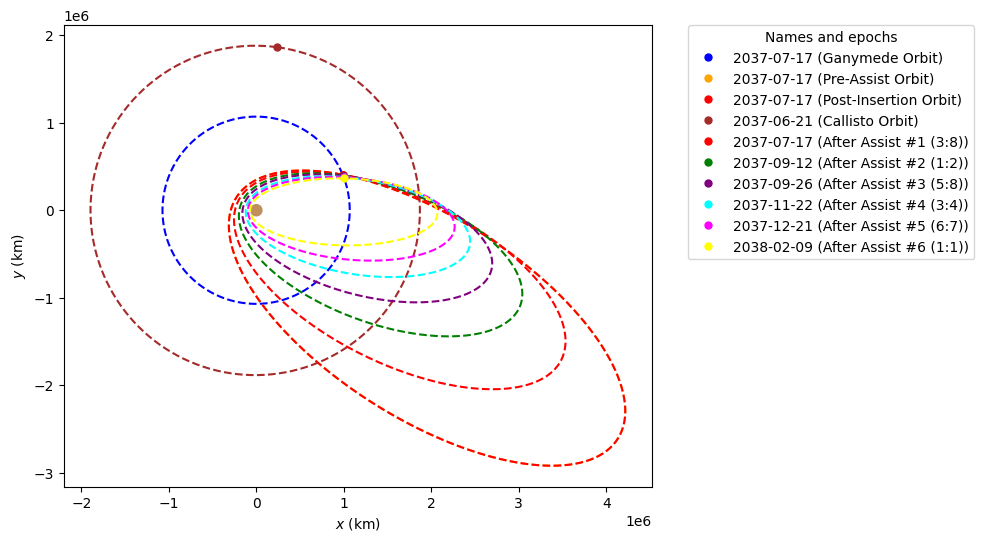

In [55]:
initial_orbit = post_insertion_orb

# Test the resonant slingshot function
r_p_min_test = 10 * u.km
r_p_max_test = 5000 * u.km

# Number of gravity assists to perform
num_assists = 6

# Storage for results
orbits_list = []
resonances_list = []
rp_list = []
dv_list = []
encounter_dates = [first_assist_date]

# Current state
current_orbit = initial_orbit
current_date = first_assist_date

# Loop through gravity assists
for assist_num in range(1, num_assists + 1):
    print("=" * 60)
    print(f"GANYMEDE ENCOUNTER #{assist_num}")
    print("=" * 60)
    
    # Get Ganymede's position at this encounter
    ganymede_orb_current = placeholder_ganymede_orbit.propagate(current_date)
    
    # Search for resonant orbit
    test_orbit, test_resonance, test_rp = search_for_resonant_orbit(
        ganymede_orb_current, 
        Ganymede, 
        current_orbit.rv()[1], 
        r_p_min_test, 
        r_p_max_test,
        num_samples=1500
    )
    
    if test_orbit is None:
        print(f"No resonant orbit found for encounter #{assist_num}")
        break
    
    # Calculate required period for exact resonance
    required_resonance_time = (test_resonance[1] / test_resonance[0]) * ganymede_orb_current.period
    dif = test_orbit.period - required_resonance_time
    
    print(f"\n=== Encounter #{assist_num} Results ===")
    print(f"Resonance found: {test_resonance[0]}:{test_resonance[1]}")
    print(f"Spacecraft does {test_resonance[0]} orbits while Ganymede does {test_resonance[1]}")
    print(f"Post-assist orbit period: {test_orbit.period.to(u.day):.2f}, it should be close to {required_resonance_time.to(u.day):.2f}")
    print(f"Flyby periapsis altitude: {(test_rp - Ganymede.R).to(u.km):.0f}")
    print(f"Eccentricity: {test_orbit.ecc:.3f}")
    
    # Apply delta-v correction to achieve exact resonance
    norm_vel_vec = test_orbit.rv()[1] / np.linalg.norm(test_orbit.rv()[1])
    total_dv = 0 * u.km/u.s
    dv_adjust = 0.001 * u.km/u.s
    
    if dif < 0:
        # Need to accelerate
        orbit_is_accurate = False
        while not orbit_is_accurate:
            total_dv += dv_adjust
            delta_v = dv_adjust
            burn = delta_v * norm_vel_vec
            maneuver = Maneuver((0*u.s, burn))
            test_orbit = test_orbit.apply_maneuver(maneuver)
            dif = test_orbit.period - required_resonance_time
            if dif >= 0:
                orbit_is_accurate = True
    
    if dif > 0:
        # Need to decelerate
        orbit_is_accurate = False
        while not orbit_is_accurate:
            total_dv += dv_adjust
            delta_v = dv_adjust
            burn = -delta_v * norm_vel_vec
            maneuver = Maneuver((0*u.s, burn))
            test_orbit = test_orbit.apply_maneuver(maneuver)
            dif = test_orbit.period - required_resonance_time
            if dif <= 0:
                orbit_is_accurate = True
    
    print(f"Total delta-v to adjust orbit: {total_dv.to(u.m/u.s):.2f}")
    
    # Store results
    orbits_list.append(test_orbit)
    resonances_list.append(test_resonance)
    rp_list.append(test_rp)
    dv_list.append(total_dv)
    
    # Calculate time to next encounter
    time_to_return = test_resonance[0] * test_orbit.period
    print(f"\nTime until next Ganymede encounter: {time_to_return.to(u.day):.2f}")
    
    # Update state for next iteration
    current_date = current_date + time_to_return
    current_orbit = test_orbit.propagate(time_to_return)
    encounter_dates.append(current_date)

# Print summary
# if len(orbits_list) > 0:
# Print summary
if len(orbits_list) > 0:
    print("\n" + "=" * 60)
    print("MISSION SUMMARY")
    print("=" * 60)
    
    # Visualize all orbits
    plotter = StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
    plotter.plot(ganymede_orb, label="Ganymede Orbit", color="blue")
    plotter.plot(initial_orbit, label="Pre-Assist Orbit", color="orange")
    plotter.plot(post_insertion_orb, label="Post-Insertion Orbit", color="red")
    plotter.plot(callisto_orb, label="Callisto Orbit", color="brown")
    
    colors = ["red", "green", "purple", "cyan", "magenta", "yellow", "brown", "pink"]
    for i, orbit in enumerate(orbits_list):
        color = colors[i % len(colors)]
        plotter.plot(orbit, label=f"After Assist #{i+1} ({resonances_list[i][0]}:{resonances_list[i][1]})", color=color)
    
    # Print statistics
    total_dv = sum(dv_list)
    total_time = sum([(resonances_list[i][0] * orbits_list[i].period) for i in range(len(orbits_list))])
    
    print(f"\nCompleted {len(orbits_list)} gravity assists")
    print(f"Total ΔV for resonance corrections: {total_dv.to(u.m/u.s):.2f}")
    print(f"Total mission time: {total_time.to(u.day):.2f}")
    
    print(f"\nEncounter dates:")
    for i, date in enumerate(encounter_dates[:-1]):
        print(f"  Encounter #{i+1}: {date}")
    print(f"  Next encounter (#{len(encounter_dates)}): {encounter_dates[-1]}")
    
    print(f"\nResonances achieved:")
    for i, res in enumerate(resonances_list):
        print(f"  Assist #{i+1}: {res[0]}:{res[1]} (period = {orbits_list[i].period.to(u.day):.2f})")
    
    print(f"\nPeriapsis altitudes:")
    for i, rp in enumerate(rp_list):
        altitude = (rp - Ganymede.R).to(u.km)
        print(f"  Assist #{i+1}: {altitude:.0f} ({rp.to(u.km):.0f} from center)")
    
    print(f"\nDelta-v per assist:")
    for i, dv in enumerate(dv_list):
        print(f"  Assist #{i+1}: {dv.to(u.m/u.s):.2f}")
else:
    print("No resonant orbits found - try adjusting periapsis bounds or tolerance")
    
    

In [62]:
initial_orb=match_orbit_plane(orbits_list[-1],placeholder_callisto_orbit)
start_date=initial_orb.epoch
callisto_ephem=Ephem.from_horizons(504,epochs= start_date, attractor= Jupiter, plane=Planes.EARTH_ECLIPTIC)
active_callisto_orb=Orbit.from_ephem(Jupiter,callisto_ephem,start_date)


transfer_to_callisto=get_single_burn_elliptical_hohmann(
    Callisto,initial_orb,2*u.day,45*u.day,tof_step=0.01*u.day,max_revs=6)



Getting ephems from 2038-02-10 02:36:03.039.


In [63]:
print(transfer_to_callisto[0])
print((transfer_to_callisto[1].r_p/Jupiter.R).value)


77.60517947949093 m / s
0.0009917188507591627


Callisto arrival v inf: 6.414798143810159 km / s


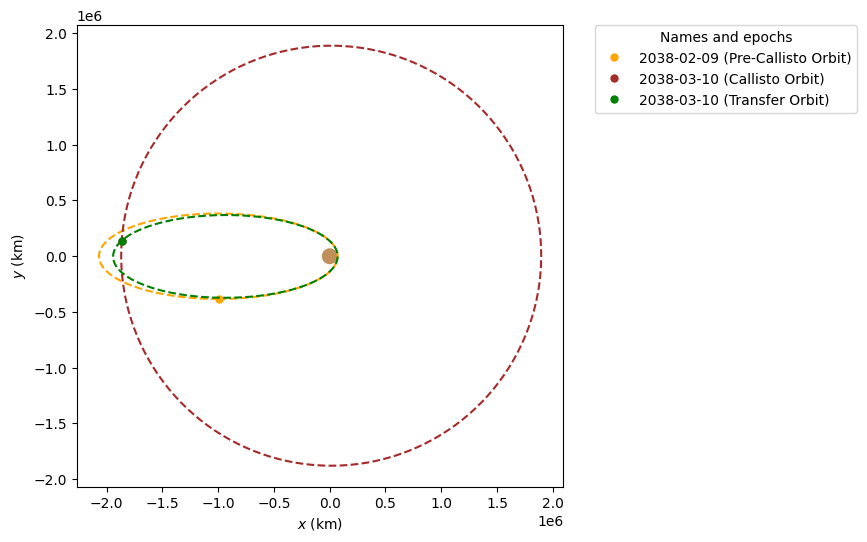

In [64]:
plotter=StaticOrbitPlotter(plane=Planes.EARTH_ECLIPTIC)
flyby_callist_orb=transfer_to_callisto[1].propagate(transfer_to_callisto[3])

plotter.plot(initial_orb,label="Pre-Callisto Orbit", color="orange")
plotter.plot(transfer_to_callisto[2],label="Callisto Orbit", color="brown")
plotter.plot(flyby_callist_orb,label="Transfer Orbit", color="green")
print(f"Callisto arrival v inf: {np.linalg.norm(flyby_callist_orb.rv()[1]-transfer_to_callisto[2].rv()[1])}")
